In [226]:
import pandas as pd
import sqlite3
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split
# import lgbm regressor
from lightgbm import LGBMRegressor

# import mean squared error from sklearn metrics
from sklearn.metrics import mean_squared_error
# import all regression metrics from sklearn metrics
from sklearn.metrics import *



# change pandas config to see all columns
pd.set_option('display.max_columns', 500)

# get data from acitivities table in strava.db
conn = sqlite3.connect('strava.db')
df = pd.read_sql_query("SELECT * FROM activities", conn)
conn.close()


In [227]:
df.shape

(1231, 21)

In [228]:
df.head()

activity_id  suffer_score  max_hr  mean_hr  mean_watts calories  \
0   8138190331          45.0   166.0    134.5       142.6     None   
1   8133847455          11.0   142.0    102.2         NaN     None   
2   8119878838          20.0   159.0    110.8         NaN     None   
3   8112713879          74.0   168.0    146.1       177.2     None   
4   8106924057         117.0   167.0    144.9       173.5     None   

     moving_time   elapsed_time     type                 start_date  \
0  2820000000000  2989000000000     Ride  2022-11-19 08:51:34+00:00   
1  3486000000000  3486000000000  Workout  2022-11-18 05:32:00+00:00   
2  3132000000000  3132000000000  Workout  2022-11-15 05:20:45+00:00   
3  2787000000000  2925000000000     Ride  2022-11-13 14:20:28+00:00   
4  4682000000000  5496000000000     Ride  2022-11-12 13:10:59+00:00   

              name  weighted_mean_watts  elev_gain  kilojoules  average_speed  \
0    Morning Ride                   NaN      146.8       402.2           3.82   
1      MMA Fitness                  NaN        0.0         NaN           0.00   
2     MMA Fitness                   NaN        0.0         NaN           0.00   
3  Afternoon Ride                   NaN      334.0       493.9           3.16   
4   Afternoon Ride                  NaN      344.0       812.6           4.83   

   distance  year        date  hour  moving_time_min  elapsed_time_min  
0   10767.3  2022  2022-11-19     8        47.000000         49.816667  
1       0.0  2022  2022-11-18     5        58.100000         58.100000  
2       0.0  2022  2022-11-15     5        52.200000         52.200000  
3    8811.4  2022  2022-11-13    14        46.450000         48.750000  
4   22633.4  2022  2022-11-12    13        78.033333         91.600000

# Clustering

In [229]:
# get all numerical columns except any column name with _id in it 
df_num = df.select_dtypes(include=np.number)
df_num = df_num.loc[:, ~df_num.columns.str.contains('_id')]
df_num.head()

# drop moving_time and elapsed_time
df_num = df_num.drop(['moving_time', 'elapsed_time'], axis=1)
df_num.head()


suffer_score  max_hr  mean_hr  mean_watts  weighted_mean_watts  elev_gain  \
0          45.0   166.0    134.5       142.6                  NaN      146.8   
1          11.0   142.0    102.2         NaN                  NaN        0.0   
2          20.0   159.0    110.8         NaN                  NaN        0.0   
3          74.0   168.0    146.1       177.2                  NaN      334.0   
4         117.0   167.0    144.9       173.5                  NaN      344.0   

   kilojoules  average_speed  distance  year  hour  moving_time_min  \
0       402.2           3.82   10767.3  2022     8        47.000000   
1         NaN           0.00       0.0  2022     5        58.100000   
2         NaN           0.00       0.0  2022     5        52.200000   
3       493.9           3.16    8811.4  2022    14        46.450000   
4       812.6           4.83   22633.4  2022    13        78.033333   

   elapsed_time_min  
0         49.816667  
1         58.100000  
2         52.200000  
3         48.750000  
4         91.600000

In [230]:
df_num.head()

suffer_score  max_hr  mean_hr  mean_watts  weighted_mean_watts  elev_gain  \
0          45.0   166.0    134.5       142.6                  NaN      146.8   
1          11.0   142.0    102.2         NaN                  NaN        0.0   
2          20.0   159.0    110.8         NaN                  NaN        0.0   
3          74.0   168.0    146.1       177.2                  NaN      334.0   
4         117.0   167.0    144.9       173.5                  NaN      344.0   

   kilojoules  average_speed  distance  year  hour  moving_time_min  \
0       402.2           3.82   10767.3  2022     8        47.000000   
1         NaN           0.00       0.0  2022     5        58.100000   
2         NaN           0.00       0.0  2022     5        52.200000   
3       493.9           3.16    8811.4  2022    14        46.450000   
4       812.6           4.83   22633.4  2022    13        78.033333   

   elapsed_time_min  
0         49.816667  
1         58.100000  
2         52.200000  
3         48.750000  
4         91.600000

In [231]:
df_num = df_num.drop(columns=["weighted_mean_watts"])

In [232]:
# fill na with 0
df_num = df_num.fillna(0)

In [233]:
df_num = df_num.drop(columns=["year", "hour"])

In [234]:
df_num.head()

suffer_score  max_hr  mean_hr  mean_watts  elev_gain  kilojoules  \
0          45.0   166.0    134.5       142.6      146.8       402.2   
1          11.0   142.0    102.2         0.0        0.0         0.0   
2          20.0   159.0    110.8         0.0        0.0         0.0   
3          74.0   168.0    146.1       177.2      334.0       493.9   
4         117.0   167.0    144.9       173.5      344.0       812.6   

   average_speed  distance  moving_time_min  elapsed_time_min  
0           3.82   10767.3        47.000000         49.816667  
1           0.00       0.0        58.100000         58.100000  
2           0.00       0.0        52.200000         52.200000  
3           3.16    8811.4        46.450000         48.750000  
4           4.83   22633.4        78.033333         91.600000

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than

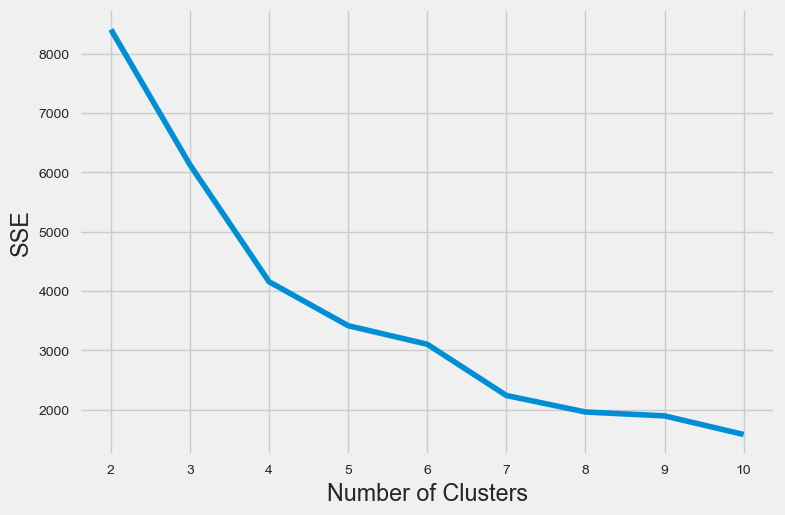

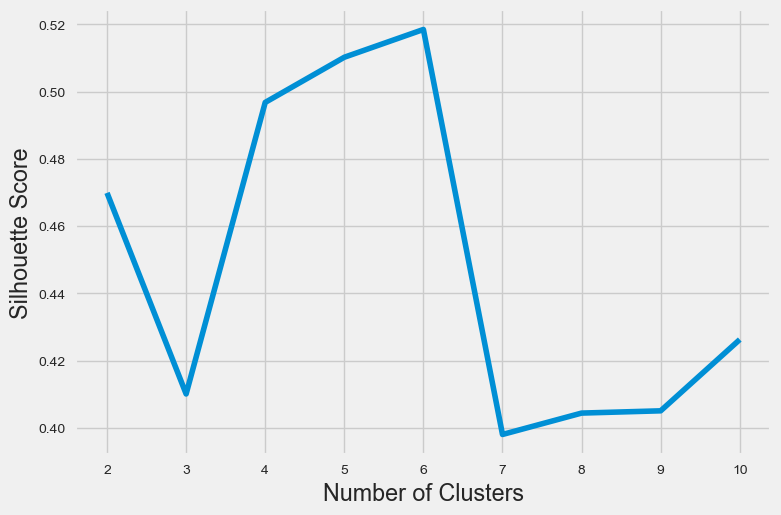

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.


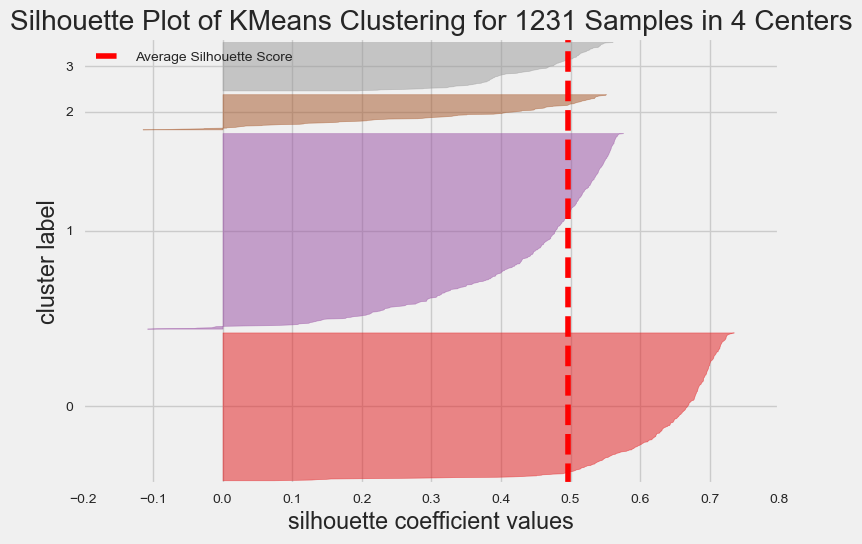

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 1231 Samples in 4 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [235]:
# scale the df_num data and run kmeans with different k values evaluate silhouette score
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

import yellowbrick.cluster as ybc

# scale the data
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_num)

# do pca on df_scaled data to get explained variance of 95%
from sklearn.decomposition import PCA
pca = PCA(n_components=0.95)
df_pca = pca.fit_transform(df_scaled)


# run kmeans with different k values and evaluate silhouette score and inertia
kmeans_kwargs = {
    "init":
    "random",
    "n_init":10,
    "max_iter":300,
    "random_state":42,
}

# A list holds the SSE values for each k
sse = []
sil_score = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    #kmeans.fit(df_scaled)
    kmeans.fit(df_pca)
    
    sse.append(kmeans.inertia_)
    #print("k:", k, " silhouette score: ",
    #        silhouette_score(df_scaled, kmeans.labels_))
    #sil_score.append(silhouette_score(df_scaled, kmeans.labels_))
    sil_score.append(silhouette_score(df_pca, kmeans.labels_))
    

# plot the elbow curve
plt.style.use("fivethirtyeight")
plt.plot(range(2, 11), sse)
plt.xticks(range(2, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

# plot the silhouette score
plt.style.use("fivethirtyeight")
plt.plot(range(2, 11), sil_score)
plt.xticks(range(2, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.show()


# plot the silhouette score
visualizer = ybc.SilhouetteVisualizer(KMeans(4, random_state=42))
#visualizer.fit(df_scaled)        # Fit the data to the visualizer
visualizer.fit(df_pca)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure



In [236]:
# use kmeans with k = 3 and plot the clusters with PCA
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca.fit(df_scaled)
df_pca = pca.transform(df_scaled)

kmeans = KMeans(n_clusters=4, **kmeans_kwargs)
kmeans.fit(df_pca)

df_res = pd.DataFrame(df_pca, columns=['pc1', 'pc2'])
df_res['cluster'] = kmeans.labels_
df_res["cluster"] = df_res.cluster.astype('str')

df_plot = pd.concat([df_res, df[["type", "distance", "suffer_score", "mean_hr", "moving_time_min"]]], axis=1)

fig = px.scatter(df_plot, x="pc1", y="pc2", color="cluster", hover_data=["type", "distance", "suffer_score", "mean_hr", "moving_time_min"])
fig.show()


#sns.scatterplot(x='pc1', y='pc2', hue='cluster', data=df_pca)
#plt.show()

# plot the clusters with t-sne
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
df_tsne = tsne.fit_transform(df_scaled)

df_tsne = pd.DataFrame(df_tsne, columns=['tsne1', 'tsne2'])
df_tsne = pd.concat([df_tsne, df[["type", "distance", "suffer_score", "mean_hr", "moving_time_min"]]], axis=1)

fig = px.scatter(df_tsne, x="tsne1", y="tsne2", color="type", hover_data=["type", "distance", "suffer_score", "mean_hr", "moving_time_min"])
fig.show()



KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.


The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.


In [237]:
df.head()

activity_id  suffer_score  max_hr  mean_hr  mean_watts calories  \
0   8138190331          45.0   166.0    134.5       142.6     None   
1   8133847455          11.0   142.0    102.2         NaN     None   
2   8119878838          20.0   159.0    110.8         NaN     None   
3   8112713879          74.0   168.0    146.1       177.2     None   
4   8106924057         117.0   167.0    144.9       173.5     None   

     moving_time   elapsed_time     type                 start_date  \
0  2820000000000  2989000000000     Ride  2022-11-19 08:51:34+00:00   
1  3486000000000  3486000000000  Workout  2022-11-18 05:32:00+00:00   
2  3132000000000  3132000000000  Workout  2022-11-15 05:20:45+00:00   
3  2787000000000  2925000000000     Ride  2022-11-13 14:20:28+00:00   
4  4682000000000  5496000000000     Ride  2022-11-12 13:10:59+00:00   

              name  weighted_mean_watts  elev_gain  kilojoules  average_speed  \
0    Morning Ride                   NaN      146.8       402.2           3.82   
1      MMA Fitness                  NaN        0.0         NaN           0.00   
2     MMA Fitness                   NaN        0.0         NaN           0.00   
3  Afternoon Ride                   NaN      334.0       493.9           3.16   
4   Afternoon Ride                  NaN      344.0       812.6           4.83   

   distance  year        date  hour  moving_time_min  elapsed_time_min  
0   10767.3  2022  2022-11-19     8        47.000000         49.816667  
1       0.0  2022  2022-11-18     5        58.100000         58.100000  
2       0.0  2022  2022-11-15     5        52.200000         52.200000  
3    8811.4  2022  2022-11-13    14        46.450000         48.750000  
4   22633.4  2022  2022-11-12    13        78.033333         91.600000

In [238]:
# perform dbscan clustering on df_scaled data and plot the clusters
from sklearn.cluster import DBSCAN

df_plot = df.copy()

dbscan = DBSCAN(eps=0.25, min_samples=20)
#dbscan = DBSCAN()
dbscan.fit(df_pca)

df_plot = pd.DataFrame(df_pca, columns=['pc1', 'pc2'])
df_plot['cluster'] = dbscan.labels_
df_plot["cluster"] = df_plot.cluster.astype('str')

df_plot = pd.concat([df_plot, df[["type", "distance", "suffer_score", "mean_hr", "moving_time_min"]]], axis=1)

# show clusters
#sns.scatterplot(x='pc1', y='pc2', hue='cluster', data=df_pca)
#plt.show()

# scatterpplot with plotly and discrete legend of cluster column and hoover text
fig = px.scatter(df_plot, x="pc1", y="pc2", color="cluster", hover_data=["type", "distance", "suffer_score", "mean_hr", "moving_time_min"])
#fig = px.scatter(df_plot, x="pc1", y="pc2", color="type", hover_data=["cluster", "distance", "suffer_score", "mean_hr", "moving_time_min"])
fig.show()


In [239]:

# plot the clusters with umap
import umap

umap = umap.UMAP(n_neighbors=5, n_components=2, random_state=42)
df_umap = umap.fit_transform(df_scaled)

df_umap = pd.DataFrame(df_umap, columns=['umap1', 'umap2'])

df_umap = pd.concat([df_umap, df[["type", "distance", "suffer_score", "mean_hr", "moving_time_min"]]], axis=1)

# scatter plot with plotly and legend of type column and hoover text
fig = px.scatter(df_umap, x="umap1", y="umap2", color="type", hover_data=["type", "distance", "suffer_score", "mean_hr", "moving_time_min"])
fig.show()




In [240]:
data = df_scaled.copy()

# plot the clusters with umap
import umap

def draw_umap(n_neighbors=15, min_dist=0.1, n_components=2, metric='euclidean', title=''):
    fit = umap.UMAP(
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        n_components=n_components,
        metric=metric
    )
    u = fit.fit_transform(data)
    u2 = pd.concat([pd.DataFrame(u, columns=["umap1", "umap2"]), df], axis=1)
    #fig = plt.figure()
    #if n_components == 3:
    #    ax = fig.add_subplot(111)
        #ax.scatter(u2[:,0], u[:,1]), c=data)
    #    sns.scatterplot(data=u2, x="umap1", y="umap2", hue="type")

    # create a plotly scatterplot of the umap data and add the hover text to the plotly figure object 
    fig = px.scatter(u2, x="umap1", y="umap2", color="type", hover_data=["suffer_score", "distance", "type", "mean_hr", "mean_watts", "moving_time_min"])
    fig.update_layout(title=title)
    fig.show()



In [241]:
for n in (2, 5, 10, 20, 50, 100, 200):
    draw_umap(n_neighbors=n, title='n_neighbors = {}'.format(n))

In [242]:
for d in (0.0, 0.1, 0.25, 0.5, 0.8, 0.99):
    draw_umap(min_dist=d, title='min_dist = {}'.format(d))

# Predict Watts

In [243]:
df_pred = df.copy()

In [244]:
# add a suffer_score missing indicator column
df_pred["suffer_score_missing"] = df_pred["suffer_score"].isnull()
df_pred["suffer_score_missing"] = df_pred["suffer_score_missing"].astype('int')

# add a suffer_score missing indicator column
df_pred["calories_missing"] = df_pred["calories"].isnull()
df_pred["calories_missing"] = df_pred["calories_missing"].astype('int')
df_pred["calories"] = df_pred["calories"].fillna(0)


df_pred["start_date"] = pd.to_datetime(df_pred["start_date"])
df_pred["date"] = pd.to_datetime(df_pred["date"])



df_pred = df_pred.sort_values("start_date", ascending=True)

# obtain number of days between current start_date and previous start_date for each row in df_pred 
df_pred["days_since"] = df_pred.start_date.diff().dt.days
# get suffer score from previous row for each row in df_pred 
df_pred["suffer_score_prev"] = df_pred.suffer_score.shift(1)
# get heartrate from previous row for each row in df_pred
df_pred["mean_hr"] = df_pred.mean_hr.shift(1)
# get max_hr from previous row for each row in df_pred
df_pred["max_hr"] = df_pred.max_hr.shift(1)
# get watts from previous row for each row in df_pred
df_pred["mean_watts"] = df_pred.mean_watts.shift(1)
# get elapsed_time from previous row for each row in df_pred
df_pred["moving_time_min"] = df_pred.moving_time_min.shift(1)

In [245]:
# create a full date range for the dataframe for every day from min to max date in the dataframe 
# and then merge the dataframe with the full date range
# this will create a dataframe with all dates and all columns from the original dataframe
# and fill all missing values with NaN
df_full = pd.DataFrame({'date': pd.date_range(df.date.min(), df.date.max(), freq='1d')})
df_full = df_full.merge(df_pred, on='date', how='left')

# if id is null fill all float columns with 0
cond = df_full["activity_id"].isnull()
df_full.loc[cond, df_full.select_dtypes("float").columns] = 0

In [246]:
# create rolling mean, std, max features for float columns for 7, 14, 30, 60, 90 days but dont include current row
for col in df_full.select_dtypes("float").columns:
    if col not in ["activity_id", "hour"]:
        for days in [7, 14, 30, 60, 90]:
            df_full[f"{col}_rolling_mean_{days}"] = df_full[col].rolling(days).mean().shift(1)
            df_full[f"{col}_rolling_std_{days}"] = df_full[col].rolling(days).std().shift(1)
            df_full[f"{col}_rolling_max_{days}"] = df_full[col].rolling(days).max().shift(1)
            #df_full[f"{col}_rolling_mean_{days}"] = df_full[col].rolling(days).mean()
            #df_full[f"{col}_rolling_std_{days}"] = df_full[col].rolling(days).std()
            #df_full[f"{col}_rolling_max_{days}"] = df_full[col].rolling(days).max()

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, us

In [247]:
# if id is greater than 0 create a new column with the value 1 else 0
df_full["id_not_null"] = df_full["activity_id"].apply(lambda x: 1 if x > 0 else 0)
df_full["cumsum"] = df_full["id_not_null"].cumsum()
df_full["cumcount"] = df_full.groupby("cumsum").cumcount()
df_full["cumcount_shift"] = df_full["cumcount"].shift(1)



DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`


In [248]:
df_train = df_full.copy()
cond = df_train["weighted_mean_watts"].gt(0)
df_train = df_train[cond].copy()

#cond = df_train["name"].str.lower().str.contains("sufferfest")
df_train["name"] = df_train["name"].str.replace("The Sufferfest", "Wahoo SYSTM", regex=False)

cond = df_train["type"] == "VirtualRide"

cond2 = df_train["name"].str.contains("Wahoo")
cond2.fillna(False, inplace=True)
df_train = df_train[cond | cond2].copy()

# convert year to int
df_train["year"] = df_train["year"].astype(int)

In [249]:
cols_drop = (
    ["name", "start_date", "date", "suffer_score", "cumsum", "cumcount", "id_not_null" ,"type",
    "name", "mean_watts", "kilojoules", "average_speed", "distance", "max_hr"]
)
df_train = df_train.drop(cols_drop, axis=1)

In [250]:
df_train.head()

activity_id  mean_hr  calories   moving_time  elapsed_time  \
1962  2.260468e+09    153.1       0.0  2.782000e+12  2.782000e+12   
1963  2.262934e+09      NaN       0.0  2.728000e+12  2.728000e+12   
1975  2.292542e+09    145.4       0.0  2.652000e+12  2.652000e+12   
1991  2.333143e+09    152.7       0.0  2.419000e+12  2.419000e+12   
1992  2.333139e+09      NaN       0.0  7.280000e+11  7.280000e+11   

      weighted_mean_watts  elev_gain  year  hour  moving_time_min  \
1962                214.0      248.0  2019  18.0        68.350000   
1963                220.0      380.0  2019  18.0        46.366667   
1975                201.0      148.0  2019  19.0        32.166667   
1991                221.0        0.0  2019  10.0        97.100000   
1992                203.0       18.0  2019  11.0        40.316667   

      elapsed_time_min  suffer_score_missing  calories_missing  days_since  \
1962         46.366667                   1.0               1.0         2.0   
1963         45.466667                   1.0               1.0         1.0   
1975         44.200000                   1.0               1.0         3.0   
1991         40.316667                   1.0               1.0         2.0   
1992         12.133333                   1.0               1.0         0.0   

      suffer_score_prev  suffer_score_rolling_mean_7  \
1962              141.0                    30.285714   
1963                NaN                          NaN   
1975               49.0                     7.000000   
1991              200.0                    66.000000   
1992                NaN                          NaN   

      suffer_score_rolling_std_7  suffer_score_rolling_max_7  \
1962                   55.529915                       141.0   
1963                         NaN                         NaN   
1975                   18.520259                        49.0   
1991                   85.906926                       200.0   
1992                         NaN                         NaN   

      suffer_score_rolling_mean_14  suffer_score_rolling_std_14  \
1962                     18.071429                    41.166574   
1963                           NaN                          NaN   
1975                           NaN                          NaN   
1991                     44.642857                    69.854362   
1992                           NaN                          NaN   

      suffer_score_rolling_max_14  suffer_score_rolling_mean_30  \
1962                        141.0                     35.433333   
1963                          NaN                           NaN   
1975                          NaN                           NaN   
1991                        200.0                           NaN   
1992                          NaN                           NaN   

      suffer_score_rolling_std_30  suffer_score_rolling_max_30  \
1962                    55.486987                        154.0   
1963                          NaN                          NaN   
1975                          NaN                          NaN   
1991                          NaN                          NaN   
1992                          NaN                          NaN   

      suffer_score_rolling_mean_60  suffer_score_rolling_std_60  \
1962                     31.633333                    53.618858   
1963                           NaN                          NaN   
1975                           NaN                          NaN   
1991                           NaN                          NaN   
1992                           NaN                          NaN   

      suffer_score_rolling_max_60  suffer_score_rolling_mean_90  \
1962                        154.0                     26.811111   
1963                          NaN                           NaN   
1975                          NaN                           NaN   
1991                          NaN                           NaN   
1992                          NaN            

In [251]:
import wandb

In [252]:
wandb.init(project="trainer_pulse_prediction")

In [253]:
target = "mean_hr"

df_train2 = df_train.copy()

df_train2.dropna(subset=[target, "activity_id"], inplace=True)

y = df_train2[target]
X = df_train2.drop(target, axis=1)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# instantiate lgbm regressor
lgbm = LGBMRegressor(random_state=42)

# fit lgbm regressor to training data
lgbm.fit(X_train, y_train)

# make predictions on test data
y_pred = lgbm.predict(X_test)

# use all metrics to evaluate predictions on both train and test data
print("Train RMSE:", np.sqrt(mean_squared_error(y_train, lgbm.predict(X_train))))
print("Test RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("Train MAE:", mean_absolute_error(y_train, lgbm.predict(X_train)))
print("Test MAE:", mean_absolute_error(y_test, y_pred))
print("Train R2:", r2_score(y_train, lgbm.predict(X_train)))
print("Test R2:", r2_score(y_test, y_pred))

# create dataframe with feature importance
feature_importance = pd.DataFrame({"feature": X_train.columns, "importance": lgbm.feature_importances_})
# sort dataframe by feature importance
feature_importance = feature_importance.sort_values("importance", ascending=False)



Train RMSE: 2.4157649235419467
Test RMSE: 5.60044450971873
Train MAE: 1.3859589707474487
Test MAE: 4.33567480067352
Train R2: 0.9551183895866855
Test R2: 0.6819419856528356


In [254]:
feature_importance.head(30)

feature  importance
13                   suffer_score_prev          42
8                      moving_time_min          32
4                  weighted_mean_watts          16
286    suffer_score_prev_rolling_max_7          16
169       average_speed_rolling_max_14          12
91           moving_time_rolling_max_7           9
2                          moving_time           9
168       average_speed_rolling_std_14           9
213     moving_time_min_rolling_std_14           9
30                max_hr_rolling_std_7           8
33               max_hr_rolling_std_14           7
46               mean_hr_rolling_max_7           6
14         suffer_score_rolling_mean_7           6
287  suffer_score_prev_rolling_mean_14           6
198                year_rolling_std_14           5
209     moving_time_min_rolling_mean_7           5
297   suffer_score_prev_rolling_std_90           5
214     moving_time_min_rolling_max_14           5
19         suffer_score_rolling_max_14           5
52              mean_hr_rolling_max_30           5
31                max_hr_rolling_max_7           4
177       average_speed_rolling_std_90           4
272         days_since_rolling_mean_14           4
20        suffer_score_rolling_mean_30           4
174       average_speed_rolling_std_60           4
291   suffer_score_prev_rolling_std_30           4
164       average_speed_rolling_mean_7           4
140          elev_gain_rolling_mean_30           3
34               max_hr_rolling_max_14           3
185           distance_rolling_mean_30           3

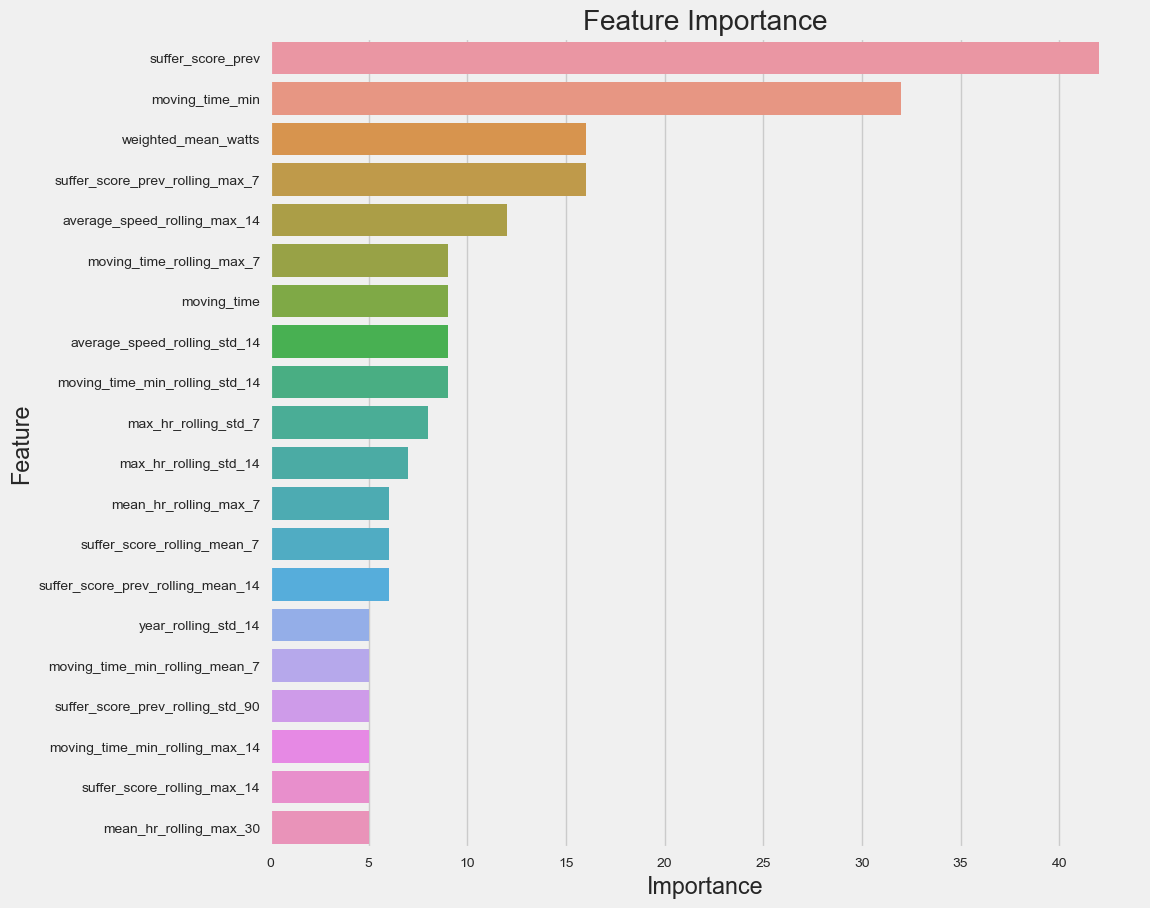

In [255]:
# make bar plot of feature importance with title and axis labels 
plt.figure(figsize=(10, 10))
sns.barplot(x="importance", y="feature", data=feature_importance[:20])
plt.title("Feature Importance")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()


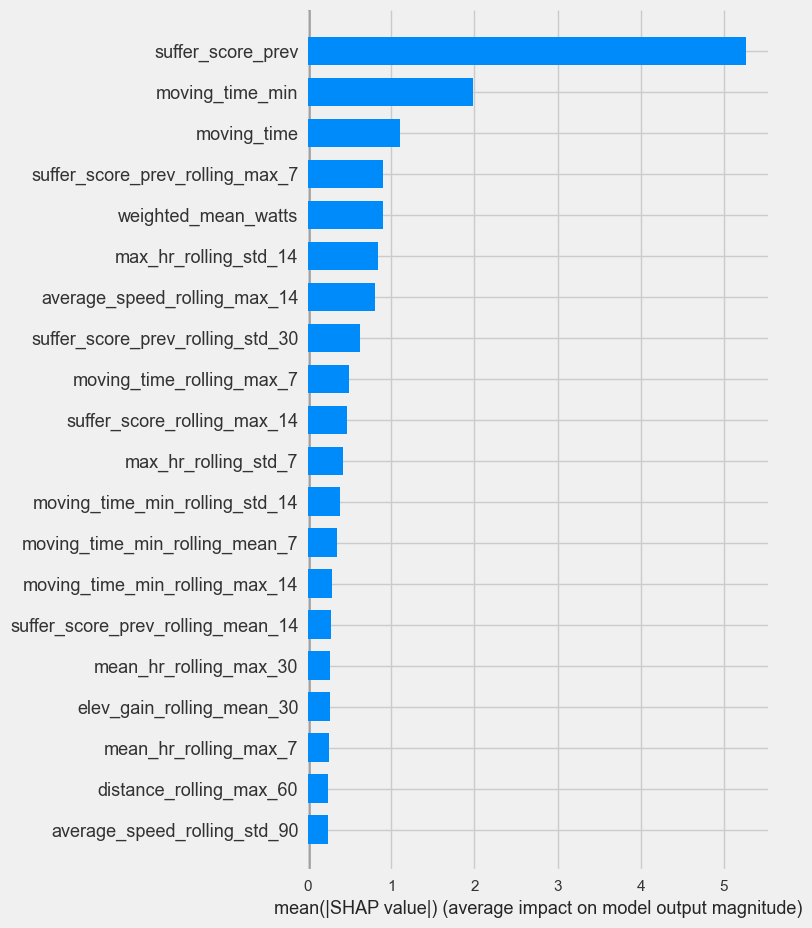

In [256]:
# import shap library for shap values and summary plots 
import shap

# create shap explainer object
explainer = shap.TreeExplainer(lgbm)

# calculate shap values for test data
shap_values = explainer.shap_values(X_test)

# create shap summary plot
shap.summary_plot(shap_values, X_test, plot_type="bar")


In [257]:
# activate javascript for shapley force plot
shap.initjs()

In [258]:
# create shapley force plot for the first row in the test data
explainer = shap.TreeExplainer(lgbm)
shap_values = explainer.shap_values(X_test)


In [259]:
shap.force_plot(explainer.expected_value, shap_values[0,:], X_test.iloc[0,:])


In [260]:
cond = df_train.activity_id == 8096588246
df_train[cond]

activity_id  mean_hr  calories   moving_time  elapsed_time  \
3435  8.096588e+09    141.1       0.0  2.791000e+12  2.791000e+12   

      weighted_mean_watts  elev_gain  year  hour  moving_time_min  \
3435                221.0        0.0  2022  12.0        51.716667   

      elapsed_time_min  suffer_score_missing  calories_missing  days_since  \
3435         46.516667                   0.0               1.0         2.0   

      suffer_score_prev  suffer_score_rolling_mean_7  \
3435               60.0                         29.0   

      suffer_score_rolling_std_7  suffer_score_rolling_max_7  \
3435                   36.373067                        72.0   

      suffer_score_rolling_mean_14  suffer_score_rolling_std_14  \
3435                     33.214286                    41.346898   

      suffer_score_rolling_max_14  suffer_score_rolling_mean_30  \
3435                        119.0                     33.233333   

      suffer_score_rolling_std_30  suffer_score_rolling_max_30  \
3435                    38.551965                        119.0   

      suffer_score_rolling_mean_60  suffer_score_rolling_std_60  \
3435                     27.766667                    39.750649   

      suffer_score_rolling_max_60  suffer_score_rolling_mean_90  \
3435                        120.0                     34.711111   

      suffer_score_rolling_std_90  suffer_score_rolling_max_90  \
3435                    47.515638                        172.0   

      max_hr_rolling_mean_7  max_hr_rolling_std_7  max_hr_rolling_max_7  \
3435              72.714286             90.694936                 171.0   

      max_hr_rolling_mean_14  max_hr_rolling_std_14  max_hr_rolling_max_14  \
3435               93.071429              84.347691                  176.0   

      max_hr_rolling_mean_30  max_hr_rolling_std_30  max_hr_rolling_max_30  \
3435                    87.9              83.978795                  176.0   

      max_hr_rolling_mean_60  max_hr_rolling_std_60  max_hr_rolling_max_60  \
3435               66.766667               82.66378                  176.0   

      max_hr_rolling_mean_90  max_hr_rolling_std_90  max_hr_rolling_max_90  \
3435                    71.2              83.919598                  183.0   

      mean_hr_rolling_mean_7  mean_hr_rolling_std_7  mean_hr_rolling_max_7  \
3435               61.442857              76.720572                  149.9   

      mean_hr_rolling_mean_14  mean_hr_rolling_std_14  mean_hr_rolling_max_14  \
3435                76.628571               69.830877                   151.7   

      mean_hr_rolling_mean_30  mean_hr_rolling_std_30  mean_hr_rolling_max_30  \
3435                73.596667               70.612261                   151.7   

      mean_hr_rolling_mean_60  mean_hr_rolling_std_60  mean_hr_rolling_max_60  \
3435                55.853333               69.364858                   151.7   

      mean_hr_rolling_mean_90  mean_hr_rolling_std_90  mean_hr_rolling_max_90  \
3435                59.861111               70.729735                   155.8   

      mean_watts_rolling_mean_7  mean_watts_rolling_std_7  \
3435                        NaN                       NaN   

      mean_watts_rolling_max_7  mean_watts_rolling_mean_14  \
3435                       NaN                         NaN   

      mean_watts_rolling_std_14  mean_watts_rolling_max_14  \
3435                        NaN                        NaN   

      mean_watts_rolling_mean_30  mean_watts_rolling_std_30  \
3435                         NaN                        NaN   

      mean_watts_rolling_max_30  mean_watts_rolling_mean_60  \
3435                        NaN                         NaN   

      mean_watts_rolling_std_60  mean_watts_rolling_max_60  \
3435                        NaN                        NaN   

      mean_watts_rolling_mean_90  mean_watts_rolling_std_90  \
3435                         NaN                        NaN   

      mean_watts_rolling_max_90  calories_rolling_mean_7 

In [261]:
shap_values2 = explainer.shap_values(df_train[cond].drop(columns=[target, "activity_id"], axis=1))
shap.force_plot(explainer.expected_value, shap_values2[0,:], df_train2[cond].drop(columns=[target, "activity_id"], axis=1).iloc[0,:])

LightGBMError: The number of features in data (299) is not the same as it was in training data (300).
You can set ``predict_disable_shape_check=true`` to discard this error, but please be aware what you are doing.

In [ ]:
df.head(10)

activity_id  suffer_score  max_hr  mean_hr  mean_watts calories  \
0   8138190331          45.0   166.0    134.5       142.6     None   
1   8133847455          11.0   142.0    102.2         NaN     None   
2   8119878838          20.0   159.0    110.8         NaN     None   
3   8112713879          74.0   168.0    146.1       177.2     None   
4   8106924057         117.0   167.0    144.9       173.5     None   
5   8096588246          86.0   169.0    150.4       199.4     None   
6   8085387433          60.0   170.0    141.1         NaN     None   
7   8075411412          71.0   170.0    137.2       168.4     None   
8   8061003811          72.0   168.0    143.0         NaN     None   
9   8053377434          93.0   171.0    149.9       184.6     None   

     moving_time   elapsed_time     type                 start_date  \
0  2820000000000  2989000000000     Ride  2022-11-19 08:51:34+00:00   
1  3486000000000  3486000000000  Workout  2022-11-18 05:32:00+00:00   
2  3132000000000  3132000000000  Workout  2022-11-15 05:20:45+00:00   
3  2787000000000  2925000000000     Ride  2022-11-13 14:20:28+00:00   
4  4682000000000  5496000000000     Ride  2022-11-12 13:10:59+00:00   
5  2791000000000  2791000000000     Ride  2022-11-10 12:01:13+00:00   
6  3103000000000  3103000000000  Workout  2022-11-08 05:20:55+00:00   
7  3436000000000  3436000000000     Ride  2022-11-06 07:15:17+00:00   
8  3292000000000  3292000000000  Workout  2022-11-03 05:24:29+00:00   
9  2992000000000  2992000000000     Ride  2022-11-01 15:23:48+00:00   

                                       name  weighted_mean_watts  elev_gain  \
0                             Morning Ride                   NaN      146.8   
1                               MMA Fitness                  NaN        0.0   
2                              MMA Fitness                   NaN        0.0   
3                           Afternoon Ride                   NaN      334.0   
4                            Afternoon Ride                  NaN      344.0   
5   Wahoo SYSTM: Revolver is Easy (Mash-Up)                221.0        0.0   
6                              MMA Fitness                   NaN        0.0   
7                Wahoo SYSTM: 14 Vise Grips                201.0        0.0   
8                               MMA Fitness                  NaN        0.0   
9  Wahoo SYSTM: Tasmania: Cygnet Coast Road                201.0        0.0   

   kilojoules  average_speed  distance  year        date  hour  \
0       402.2           3.82   10767.3  2022  2022-11-19     8   
1         NaN           0.00       0.0  2022  2022-11-18     5   
2         NaN           0.00       0.0  2022  2022-11-15     5   
3       493.9           3.16    8811.4  2022  2022-11-13    14   
4       812.6           4.83   22633.4  2022  2022-11-12    13   
5       556.6           8.22   22936.0  2022  2022-11-10    12   
6         NaN           0.00       0.0  2022  2022-11-08     5   
7       578.8           7.69   26430.0  2022  2022-11-06     7   
8         NaN           0.00       0.0  2022  2022-11-03     5   
9       552.4           8.29   24796.4  2022  2022-11-01    15   

   moving_time_min  elapsed_time_min  
0        47.000000         49.816667  
1        58.100000         58.100000  
2        52.200000         52.200000  
3        46.450000         48.750000  
4        78.033333         91.600000  
5        46.516667         46.516667  
6        51.716667         51.716667  
7        57.266667         57.266667  
8        54.866667         54.866667  
9        49.866667         49.866667

## Linear Regression

In [ ]:
# creaate new dataframe with any columns with missing removed
df_train_lr = df_train2.dropna(axis=1)

In [ ]:
# import linear regression
from sklearn.linear_model import LinearRegression

# make train_test_split with random_state=42 and test_size=0.2 
X_train, X_test, y_train, y_test = train_test_split(df_train_lr.drop(target, axis=1), df_train_lr[target], test_size=0.2, random_state=42)

# instantiate linear regression
lr = LinearRegression()

# fit linear regression to training data
lr.fit(X_train, y_train)

# make predictions on test data
y_pred = lr.predict(X_test)

# use all metrics to evaluate predictions on both train and test data
print("Train RMSE:", np.sqrt(mean_squared_error(y_train, lr.predict(X_train))))
print("Test RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("Train MAE:", mean_absolute_error(y_train, lr.predict(X_train)))
print("Test MAE:", mean_absolute_error(y_test, y_pred))
print("Train R2:", r2_score(y_train, lr.predict(X_train)))
print("Test R2:", r2_score(y_test, y_pred))

# create dataframe with feature importance
feature_importance = pd.DataFrame({"feature": X_train.columns, "importance": lr.coef_})
# sort dataframe by feature importance
feature_importance = feature_importance.sort_values("importance", ascending=False)


Train RMSE: 0.4275648743537994
Test RMSE: 25.17358400443622
Train MAE: 0.34566963191593797
Test MAE: 17.95906277041877
Train R2: 0.9985940718442259
Test R2: -5.4261587287360085


In [ ]:
# scale X_train and X_test using StandardScaler
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# fit linear regression to training data
lr.fit(X_train_scaled, y_train)

# make predictions on test data
y_pred = lr.predict(X_test_scaled)

# use all metrics to evaluate predictions on both train and test data
print("Train RMSE:", np.sqrt(mean_squared_error(y_train, lr.predict(X_train_scaled))))
print("Test RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("Train MAE:", mean_absolute_error(y_train, lr.predict(X_train_scaled)))
print("Test MAE:", mean_absolute_error(y_test, y_pred))
print("Train R2:", r2_score(y_train, lr.predict(X_train_scaled)))
print("Test R2:", r2_score(y_test, y_pred))


Train RMSE: 8.886858052997495e-14
Test RMSE: 16.316609105840705
Train MAE: 6.445637674395194e-14
Test MAE: 12.38398745520591
Train R2: 1.0
Test R2: -1.6997351745517584


In [ ]:
# use ridge regression to fit linear regression to training data
from sklearn.linear_model import Ridge

ridge = Ridge()
ridge.fit(X_train_scaled, y_train)

# make predictions on test data
y_pred = ridge.predict(X_test_scaled)

# use all metrics to evaluate predictions on both train and test data
print("Train RMSE:", np.sqrt(mean_squared_error(y_train, ridge.predict(X_train_scaled))))
print("Test RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("Train MAE:", mean_absolute_error(y_train, ridge.predict(X_train_scaled)))
print("Test MAE:", mean_absolute_error(y_test, y_pred))
print("Train R2:", r2_score(y_train, ridge.predict(X_train_scaled)))
print("Test R2:", r2_score(y_test, y_pred))


Train RMSE: 2.82989249593071
Test RMSE: 14.284805327169385
Train MAE: 1.9688999417454798
Test MAE: 8.430240209500585
Train R2: 0.9384115939396018
Test R2: -1.0692358720312156


In [ ]:
# use lasso regression to fit linear regression to training data
from sklearn.linear_model import Lasso

lasso = Lasso()
lasso.fit(X_train_scaled, y_train)

# make predictions on test data
y_pred = lasso.predict(X_test_scaled)

# use all metrics to evaluate predictions on both train and test data
print("Train RMSE:", np.sqrt(mean_squared_error(y_train, lasso.predict(X_train_scaled))))
print("Test RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("Train MAE:", mean_absolute_error(y_train, lasso.predict(X_train_scaled)))
print("Test MAE:", mean_absolute_error(y_test, y_pred))
print("Train R2:", r2_score(y_train, lasso.predict(X_train_scaled)))
print("Test R2:", r2_score(y_test, y_pred))


Train RMSE: 8.12288830829579
Test RMSE: 8.161153858395226
Train MAE: 5.842370333231832
Test MAE: 5.435826774795083
Train R2: 0.4925654281728261
Test R2: 0.3245946798670575


In [ ]:
np.logspace(-5,5, 11)

array([1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02,
       1.e+03, 1.e+04, 1.e+05])

In [ ]:
# plot and calculate the coefficients for the diffferent features for different values of alpha in lasso regression 
lasso = Lasso()
coefs = []
for a in np.logspace(-5,2, 11):
    lasso.set_params(alpha=a)
    lasso.fit(X_train_scaled, y_train)
    coefs.append(lasso.coef_)

# plot the coefficients for the different features for different values of alpha in lasso regression with plotly in log scale
import plotly.graph_objects as go

fig = go.Figure()
for i in range(len(coefs[0])):
    fig.add_trace(go.Scatter(x=np.logspace(-5,2, 11), y=[coef[i] for coef in coefs], name=X_train.columns[i]))
fig.update_traces(hovertemplate="%{y:.2f}")
fig.update_layout(title="Lasso Regression Coefficients", xaxis_title="Alpha", yaxis_title="Coefficient", xaxis_type="log")
fig.show()


# plot and calculate the coefficients for the diffferent features for different values of alpha in ridge regression 
ridge = Ridge()
coefs = []
for a in np.logspace(-5,2, 11):
    ridge.set_params(alpha=a)
    ridge.fit(X_train_scaled, y_train)
    coefs.append(ridge.coef_)


fig = go.Figure()
for i in range(len(coefs[0])):
    fig.add_trace(go.Scatter(x=np.logspace(-5,2, 11), y=[coef[i] for coef in coefs], name=X_train.columns[i]))
# plot the full name of the coefficient when hovering over the plot
fig.update_traces(hovertemplate="%{y:.2f}")
fig.update_layout(title="Ridge Regression Coefficients", xaxis_title="Alpha", yaxis_title="Coefficient", xaxis_type="log")
fig.show()


Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.578e+01, tolerance: 1.456e+00
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.837e+01, tolerance: 1.456e+00
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.015e+01, tolerance: 1.456e+00
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.094e+02, tolerance: 1.456e+00
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.715e+02, tolerance: 1.456e+00
Objective did n

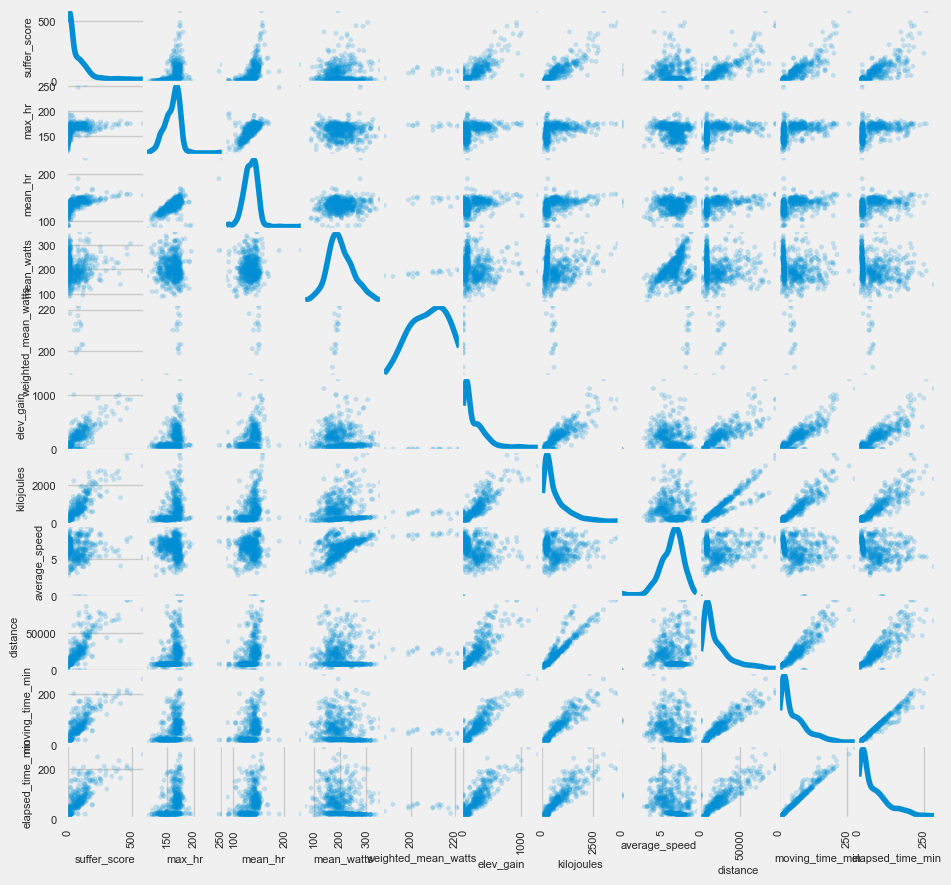

In [ ]:
cond = df.type == "Ride"
df_test = df[cond].select_dtypes("float")
# plot scatter matrix of df_test with a lower font size
pd.plotting.scatter_matrix(df_test, figsize=(10,10), alpha=0.2, diagonal="kde")
# set fontsize for x title with rcparams
plt.rcParams.update({'axes.labelsize':7, 'axes.titlesize':8})
plt.show()

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.253e+01, tolerance: 1.088e+00
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.335e+01, tolerance: 1.067e+00
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.690e+01, tolerance: 1.309e+00
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.847e+01, tolerance: 1.261e+00
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.997e+01, tolerance: 1.095e+00
Objective did n

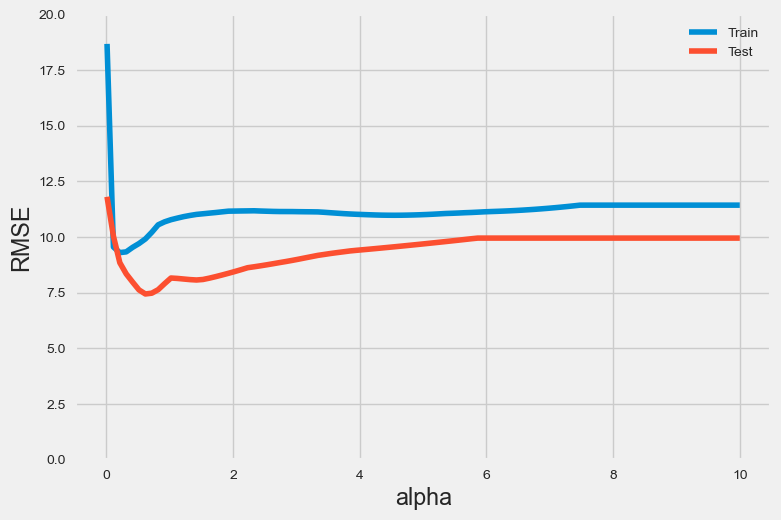

In [ ]:
# apply standard scaling within a cross validation pipeline
from sklearn.pipeline import Pipeline

pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("lr", Lasso(max_iter=2000))
])

lasso = Lasso()

# do cross validation with 5 folds and scoring="neg_mean_squared_error" and print the mean of the scores 
from sklearn.model_selection import cross_val_score

# make a sweep of alpha values and plot how the RMSE changes with alpha
alphas = np.logspace(-2, 1, 100)
alphas = np.linspace(0.01, 10, 100)
train_rmse = []
test_rmse = []
for alpha in alphas:
    pipe.set_params(lr__alpha=alpha)
    #scores = cross_val_score(pipe, X_train, y_train, cv=5, scoring="neg_mean_squared_error")
    scores = cross_val_score(pipe, X_train, y_train, cv=5, scoring="neg_mean_squared_error")
    train_rmse.append(np.sqrt(-scores.mean()))
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    test_rmse.append(np.sqrt(mean_squared_error(y_test, y_pred)))

plt.plot(alphas, train_rmse, label="Train")
plt.plot(alphas, test_rmse, label="Test")
plt.xlabel("alpha")
plt.ylabel("RMSE")
plt.legend()
plt.ylim(0, 20)
plt.show()

In [ ]:
# from lasso regression create dataframe with feature importance
feature_importance = pd.DataFrame({"feature": X_train.columns, "importance": lasso.coef_})

feature_importance["importance_abs"] = feature_importance.importance.abs()

feature_importance.sort_values("importance_abs", ascending=False).head(10)

feature  importance  importance_abs
13                      suffer_score_prev    3.579314        3.579314
77          average_speed_rolling_mean_14   -1.630893        1.630893
152  suffer_score_missing_rolling_mean_14    1.555976        1.555976
185            days_since_rolling_mean_30    1.554660        1.554660
94                distance_rolling_max_14   -1.348924        1.348924
159   suffer_score_missing_rolling_std_60    0.881466        0.881466
171       calories_missing_rolling_std_30    0.538039        0.538039
110                  year_rolling_mean_30   -0.408841        0.408841
158  suffer_score_missing_rolling_mean_60    0.307888        0.307888
2                             moving_time   -0.269080        0.269080

In [ ]:
class MyPipeline(Pipeline):
    @property
    def coef_(self):
        return self._final_estimator.coef_
    @property
    def feature_importances_(self):
        return self._final_estimator.feature_importances_38182de5e3a8005d654a6a93f862aeee15831088

Perform RFECV

The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.


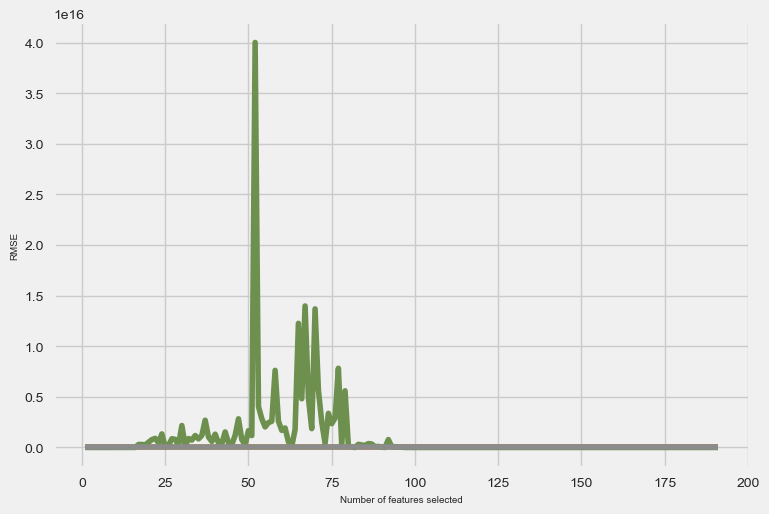

Index(['elapsed_time_rolling_std_14', 'elapsed_time_rolling_std_90',
       'elapsed_time_min_rolling_std_7', 'elapsed_time_min_rolling_std_14',
       'elapsed_time_min_rolling_std_90'],
      dtype='object')
{'lr__alpha': 2.656087782946687}
Train RMSE: 11.03723259522588
Test RMSE: 9.174872943894576
Train R2: 0.0631296836043389
Test R2: 0.14638612881027158


In [ ]:
# perform rfecv for linear regression with 5 features using cv=5 on a pipeline with standard scaling and linear regression
from sklearn.feature_selection import RFECV

pipe = MyPipeline([
    ("scaler", StandardScaler()),
    ("lr", LinearRegression())
])

rfecv = RFECV(pipe, cv=5, scoring="neg_mean_squared_error", n_jobs=-1, min_features_to_select=5)
rfecv.fit(X_train, y_train)

# plot the number of features vs the RMSE for the different number of features
plt.plot(range(1, len(rfecv.grid_scores_) + 1), np.sqrt(-rfecv.grid_scores_))
plt.xlabel("Number of features selected")
plt.ylabel("RMSE")
plt.show()



# print out the features selected by rfe
print(X_train.columns[rfecv.support_])

# perform grid search for with the best parameters for lasso regression
from sklearn.model_selection import GridSearchCV

pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("lr", Lasso(max_iter=1000))
])

param_grid = {
    "lr__alpha": np.logspace(-2, 1, 100)
}

# do grid search on rfe top features
grid = GridSearchCV(pipe, param_grid, cv=5, scoring="neg_mean_squared_error")
grid.fit(X_train[X_train.columns[rfecv.support_]], y_train)

# print out the best parameters for lasso regression
print(grid.best_params_)

# use best features and best parameters to fit a lasso regression model on X_train and y_train and print out all  metrics
lasso = Lasso(alpha=grid.best_params_["lr__alpha"])
lasso.fit(X_train[X_train.columns[rfecv.support_]], y_train)

y_pred = lasso.predict(X_test[X_test.columns[rfecv.support_]])

# print out all metrics on train and test set
print("Train RMSE:", np.sqrt(mean_squared_error(y_train, lasso.predict(X_train[X_train.columns[rfecv.support_]]))))
print("Test RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("Train R2:", r2_score(y_train, lasso.predict(X_train[X_train.columns[rfecv.support_]])))
print("Test R2:", r2_score(y_test, y_pred))


In [ ]:
# do hyperparameter tuning with GridSearchCV to find the best alpha for lasso regression 
from sklearn.model_selection import GridSearchCV

param_grid = {"lr__alpha": np.logspace(-1, 2, 100)}

grid = GridSearchCV(pipe, param_grid, cv=5, scoring="neg_mean_squared_error")
grid.fit(X_train, y_train)

# print the best alpha and the best score
print(grid.best_params_)
print(np.sqrt(-grid.best_score_))


# compute the RMSE, R2 and MAE for the test data with the best alpha
y_pred = grid.predict(X_test)
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("R2:", r2_score(y_test, y_pred))
print("MAE:", mean_absolute_error(y_test, y_pred))



Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.456e+00, tolerance: 1.067e+00
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.170e+00, tolerance: 1.309e+00
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.863e+00, tolerance: 1.261e+00
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.494e+00, tolerance: 1.095e+00
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.119e+00, tolerance: 1.067e+00
Objective did n

{'lr__alpha': 0.23101297000831597}
9.288764677681694
RMSE: 8.711796303852248
R2: 0.23037924537503873
MAE: 5.017787297244637


In [ ]:
# use elastic net regression to fit linear regression to training data
from sklearn.linear_model import ElasticNet

elastic = ElasticNet()
elastic.fit(X_train_scaled, y_train)

# make predictions on test data
y_pred = elastic.predict(X_test_scaled)

# use all metrics to evaluate predictions on both train and test data
print("Train RMSE:", np.sqrt(mean_squared_error(y_train, elastic.predict(X_train_scaled))))
print("Test RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("Train MAE:", mean_absolute_error(y_train, elastic.predict(X_train_scaled)))
print("Test MAE:", mean_absolute_error(y_test, y_pred))
print("Train R2:", r2_score(y_train, elastic.predict(X_train_scaled)))
print("Test R2:", r2_score(y_test, y_pred))


Train RMSE: 8.08155107773634
Test RMSE: 8.701106381332055
Train MAE: 5.856479129294684
Test MAE: 5.90716439453738
Train R2: 0.4977169373423379
Test R2: 0.2322668328053158


# RFE with CV

In [ ]:
# import rfecv from sklearn
from sklearn.feature_selection import RFECV

# do rfe with cv using lgbm regressor and 5 folds 
rfe = RFECV(estimator=LGBMRegressor(random_state=42), cv=5, scoring="neg_root_mean_squared_error")

# fit rfe to training data
rfe.fit(X_train, y_train)

# print number of features selected
print("Number of features selected:", rfe.n_features_)
# print features selected
print("Features selected:", X_train.columns[rfe.support_])

Number of features selected: 10
Features selected: Index(['weighted_mean_watts', 'moving_time_min', 'suffer_score_prev',
       'moving_time_rolling_max_7', 'elev_gain_rolling_mean_60',
       'average_speed_rolling_max_14', 'average_speed_rolling_mean_90',
       'distance_rolling_mean_7', 'moving_time_min_rolling_mean_7',
       'moving_time_min_rolling_std_90'],
      dtype='object')


In [ ]:
# user best features to fit lgbm regressor on training data
lgbm = LGBMRegressor(random_state=42)
lgbm.fit(X_train[X_train.columns[rfe.support_]], y_train)

# show performance metrics on train and test data
print("Train RMSE:", np.sqrt(mean_squared_error(y_train, lgbm.predict(X_train[X_train.columns[rfe.support_]]))))
print("Test RMSE:", np.sqrt(mean_squared_error(y_test, lgbm.predict(X_test[X_test.columns[rfe.support_]]))))
print("Train R2:", r2_score(y_train, lgbm.predict(X_train[X_train.columns[rfe.support_]])))
print("Test R2:", r2_score(y_test, lgbm.predict(X_test[X_test.columns[rfe.support_]])))


Train RMSE: 3.065778663092213
Test RMSE: 5.913099967938655
Train R2: 0.9277162485215801
Test R2: 0.6454383262074587


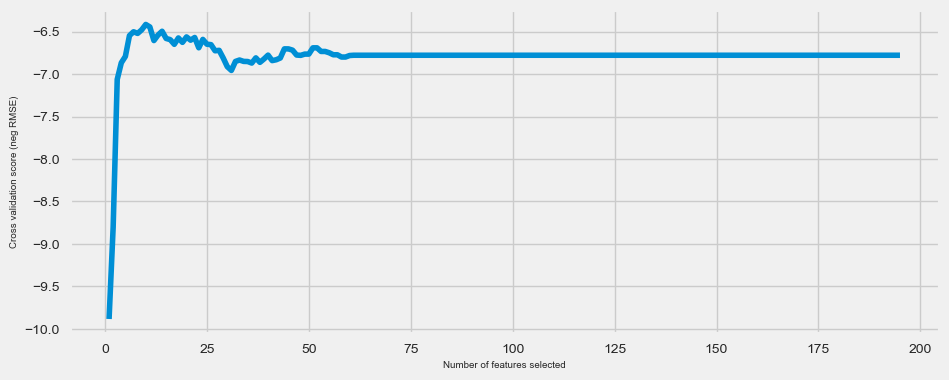

In [ ]:
# plot mean of cross validation scores for each number of features selected 
plt.figure(figsize=(10, 4))
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (neg RMSE)")
plt.plot(range(1, len(rfe.grid_scores_) + 1), rfe.cv_results_["mean_test_score"])
plt.show()



In [ ]:
# perform grid search for best parameters for lgbm regressor
from sklearn.model_selection import GridSearchCV

param_grid = {
    "n_estimators": [100, 200, 300, 400, 500],
    "max_depth": [3, 4, 5, 6, 7, 8, 9, 10],
    "learning_rate": [0.01, 0.05, 0.1, 0.2, 0.3],
    "num_leaves": [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
}

#grid = GridSearchCV(LGBMRegressor(random_state=42), param_grid, cv=5, scoring="neg_root_mean_squared_error")
grid = GridSearchCV(LGBMRegressor(random_state=42), param_grid, cv=5, scoring="neg_mean_absolute_error")
grid.fit(X_train[X_train.columns[rfe.support_]], y_train)

# print out the best parameters for lgbm regressor
print(grid.best_params_)
# print out the best score for lgbm regressor
print(np.sqrt(-grid.best_score_))

# use best parameters to fit lgbm regressor on training data
lgbm = LGBMRegressor(**grid.best_params_, random_state=42)
lgbm.fit(X_train[X_train.columns[rfe.support_]], y_train)

# show performance metrics on train and test data
print("Train RMSE:", np.sqrt(mean_squared_error(y_train, lgbm.predict(X_train[X_train.columns[rfe.support_]]))))
print("Test RMSE:", np.sqrt(mean_squared_error(y_test, lgbm.predict(X_test[X_test.columns[rfe.support_]]))))
print("Train R2:", r2_score(y_train, lgbm.predict(X_train[X_train.columns[rfe.support_]])))
print("Test R2:", r2_score(y_test, lgbm.predict(X_test[X_test.columns[rfe.support_]])))


{'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 200, 'num_leaves': 10}
2.0888155431983955
Train RMSE: 3.1837348063748054
Test RMSE: 5.800437840581108
Train R2: 0.9220469952133666
Test R2: 0.658820521934466


wandb: Network error resolved after 0:00:08.162094, resuming normal operation.


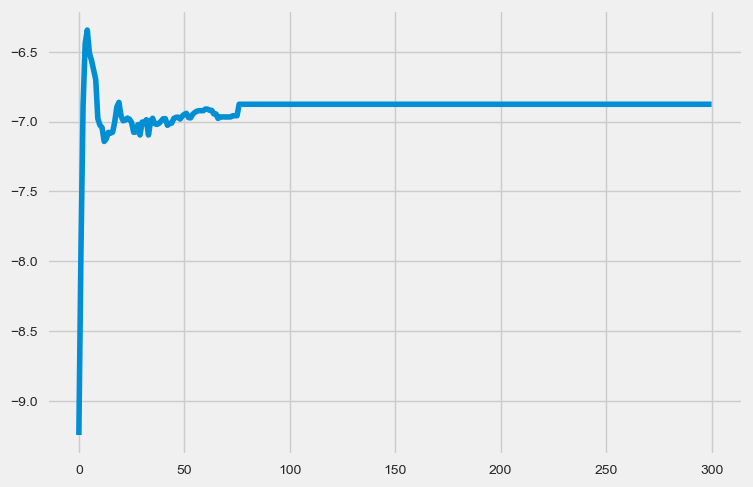

In [ ]:
plt.plot(rfe.cv_results_["mean_test_score"])